____    
    
**Название проекта:** Золото
_____
**Описание исследования.**
Подготовить прототип модели машинного обучения для «Цифры». Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
_____
**Цель исследования.**
Построить и обучить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды.
_____
**Задачи исследования.**
1. Подготовить данные
2. Провести исследовательский анализ данных
3. Построить и обучить модель
_____
**Исходные данные.**
Данные находятся в трёх файлах:
* gold_recovery_train_new.csv - обучающая выборка
* gold_recovery_test_new.csv - тестовая выборка
* gold_recovery_full_new.csv - исходные данные

В таблицах представлены следующие данные:</br></br>
Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, * Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота</br>

Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи</br>
Наименование признаков
Наименование признаков должно быть такое:</br>
[этап].[тип_параметра].[название_параметра]</br>

Возможные значения для блока [этап]:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики</br>

Возможные значения для блока [тип_параметра]:</br>
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики</br>


Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле:
![Изображение](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)
где:</br>

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.</br>

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Метрика качества</br>

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).</br>
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.</br>
Метрика sMAPE вычисляется так:
![Изображение](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

Нужно спрогнозировать сразу две величины:</br>

* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.</br>

Итоговая метрика складывается из двух величин:
![Изображение](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

______
**Условия задачи.**
* Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.</br>
* Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
* Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища
______

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***
* [1.1 Подключение библиотек.](#1-bullet)

* [1.2 Открытие и изучение данных.](#2-bullet)

***Часть 2. Подготовка данных:***
* [2.1 Переименование столбцов.](#3-bullet)
* [2.2 Проверка формулы вычисления эффективности обогащения.](#4-bullet)
* [2.3 Анализ отличия данных в выборках.](#5-bullet)
* [2.4 Исследования изменения концентрации металлов на каждом этапе.](#6-bullet)
* [2.5 Анализ распределения размера гранул в обучающей и тестовой выборках.](#7-bullet)
* [2.6 Исследования суммарных концентраций.](#8-bullet)

***Часть 3. Подбор лучшей модели:***
* [3.1 Введение функции расчета метрики.](#9-bullet)
* [3.2 Модель линейной регрессии.](#10-bullet)
* [3.3 Модель дерево решений.](#11-bullet)
* [3.4 Модель случайный лес.](#12-bullet)
* [3.5 Проведение расчета модели на тестовой выборке.](#13-bullet)

***Часть 4. Общий вывод:***
* [Общий вывод.](#14-bullet)

<a id="1-bullet"></a>
## **Подключение необходимых библиотек**

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import re
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import numpy as np

import warnings
warnings.filterwarnings("ignore")

<a id="2-bullet"></a>
## **Открытие и изучение данных**

In [ ]:
# загрузка данных
try:
  data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Золотая руда/gold_recovery_train_new.csv')
  data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Золотая руда/gold_recovery_test_new.csv')
  data_full = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Золотая руда/gold_recovery_full_new.csv')
except:
  data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
  data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
  data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Сформируем функцию первичного анализа данных

In [ ]:
# чтобы все столбцы выводились на экран
pd.set_option('display.max_columns', None)

# функция первичного анализа
def first_analysis(df):
  columns = df.columns.tolist() # формируем список из названий столбцов

  for col in columns: # для каждого  выполняем следующие команды
    print("-"*60) # линия разделитель
    print(col) # печатаем названия столбца
    print('Тип данных:', df[col].dtypes) # выводим тип данных в этом столбце
    print(f'Количество пустых ячеек: {df[col].isna().sum()} ({round(df[col].isna().sum()/df.shape[0]*100, 2)}%)') # выводим количество пустых ячеек в абсолютных значениях, а также в процентах
    print('Уникальные значения', df[col].unique()) # выводим список уникальных значений
  # далее по всей таблице
  print()
  print('Количество явных дубликатов:', df.duplicated().sum()) # Выводим количество явных дубликатов
  print()
  print('Первые пять строк таблицы данных')
  print()
  display(df.head()) # печатаем первые пять строк таблицы
  print('\n'*2)
  display(df.describe()) # выводим статистическую информацию по каждому столбцу
  print('\n'*2)
 # df.hist(figsize=(15, 20)); # строим гистограммы для каждой колонки
 # print('\n'*2)
  display(df.corr().round(2)) # строим корреляционную матрицу
 # print('\n'*2)
 # pd.plotting.scatter_matrix(df, figsize=(12, 9)); # выводим корреляционную матрицу графически

In [ ]:
first_analysis(data_train)

------------------------------------------------------------
date
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['2016-01-15 00:00:00' '2016-01-15 01:00:00' '2016-01-15 02:00:00' ...
 '2018-08-18 08:59:59' '2018-08-18 09:59:59' '2018-08-18 10:59:59']
------------------------------------------------------------
final.output.concentrate_ag
Тип данных: float64
Количество пустых ячеек: 1 (0.01%)
Уникальные значения [6.05540276 6.02936857 6.05592607 ... 3.10999751 3.36724104 3.59837494]
------------------------------------------------------------
final.output.concentrate_pb
Тип данных: float64
Количество пустых ячеек: 1 (0.01%)
Уникальные значения [ 9.88964844  9.9689441  10.21399457 ... 11.43436599 11.62558728
 11.7378318 ]
------------------------------------------------------------
final.output.concentrate_sol
Тип данных: float64
Количество пустых ячеек: 211 (1.49%)
Уникальные значения [5.50732422 5.25778148 5.38375877 ... 6.88601311 6.79943261 6.71750947]
----

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.00,0.02,0.35,-0.10,0.13,0.29,-0.10,0.05,0.19,0.02,0.14,0.02,0.17,0.50,-0.18,0.32,-0.19,-0.00,-0.06,0.17,0.19,0.19,0.04,0.20,0.05,0.17,0.04,0.10,0.01,-0.02,-0.03,-0.04,0.20,0.42,0.00,-0.18,-0.02,-0.05,0.28,-0.12,0.07,-0.14,0.09,0.29,-0.17,-0.04,0.03,0.04,0.19,-0.03,0.02,0.13,0.12,-0.19,0.12,0.08,0.10,0.09,0.13,0.08,0.19,0.10,0.15,0.10,-0.08,-0.31,0.14,0.04,-0.06,0.04,-0.03,0.04,0.05,0.18,0.03,0.21,0.04,0.17,0.02,0.01,0.01,0.23,0.02,0.20,0.17,0.06
final.output.concentrate_pb,0.02,1.00,-0.01,0.32,0.09,-0.10,0.24,0.07,0.03,0.12,0.01,-0.05,-0.18,-0.03,0.39,-0.08,0.01,-0.04,0.00,-0.02,-0.13,-0.02,0.06,-0.04,0.07,-0.01,0.06,-0.02,0.09,0.01,-0.00,0.01,-0.36,-0.17,0.32,0.02,-0.03,0.07,-0.03,0.10,-0.01,0.11,-0.02,-0.27,0.47,0.00,-0.01,0.00,-0.09,0.17,-0.22,0.01,-0.03,0.08,0.08,0.00,0.10,-0.00,0.07,-0.00,0.06,-0.01,0.11,-0.00,-0.02,0.24,-0.01,-0.06,0.08,0.04,0.11,0.07,0.04,-0.03,0.14,-0.11,-0.00,-0.04,0.09,0.07,0.10,-0.10,0.12,-0.12,-0.02,0.08
final.output.concentrate_sol,0.35,-0.01,1.00,0.22,0.25,0.23,0.26,-0.02,0.24,0.34,0.11,0.17,0.09,0.36

In [ ]:
first_analysis(data_test)

------------------------------------------------------------
date
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['2016-09-01 00:59:59' '2016-09-01 01:59:59' '2016-09-01 02:59:59' ...
 '2017-12-31 21:59:59' '2017-12-31 22:59:59' '2017-12-31 23:59:59']
------------------------------------------------------------
primary_cleaner.input.sulfate
Тип данных: float64
Количество пустых ячеек: 4 (0.08%)
Уникальные значения [210.800909   215.39245478 215.25994647 ... 171.13571781 179.6971576
 181.55685577]
------------------------------------------------------------
primary_cleaner.input.depressant
Тип данных: float64
Количество пустых ячеек: 5 (0.09%)
Уникальные значения [14.99311769 14.9874713  12.8849338  ... 15.99366947 15.43897911
 14.99584972]
------------------------------------------------------------
primary_cleaner.input.feed_size
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [8.07999992 7.78666669 7.63999987 ... 7.88999927 7.573333

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.00,0.46,0.11,0.50,0.10,0.05,0.08,0.14,0.02,0.03,0.10,-0.02,0.36,0.43,0.46,-0.01,0.42,0.44,0.62,0.56,0.58,0.53,0.24,0.22,-0.23,-0.05,-0.25,-0.05,-0.25,-0.02,-0.23,-0.12,-0.25,-0.06,0.05,-0.04,0.25,-0.01,0.14,0.00,0.15,0.02,0.31,0.12,0.35,0.07,0.09,0.13,0.16,0.07,-0.13,0.03
primary_cleaner.input.depressant,0.46,1.00,0.22,0.15,0.14,0.24,0.15,0.20,0.04,0.21,0.14,0.08,0.50,0.47,0.13,0.00,0.17,0.46,0.24,0.35,0.21,0.36,0.42,0.13,-0.36,-0.11,-0.37,-0.10,-0.35,-0.08,-0.36,-0.13,-0.38,-0.11,0.08,-0.08,0.23,-0.10,0.28,0.13,0.26,0.12,0.33,0.12,0.24,-0.09,-0.09,0.01,0.06,0.00,-0.20,0.03
primary_cleaner.input.feed_size,0.11,0.22,1.00,-0.29,-0.06,0.08,-0.06,0.07,-0.09,0.07,-0.07,0.07,0.34,0.00,0.02,-0.09,0.05,0.24,-0.19,0.22,-0.24,0.19,0.02,-0.24,0.04,0.05,0.06,0.05,-0.01,0.07,-0.01,0.01,-0.13,0.04,-0.13,0.04,-0.18,0.01,0.02,0.03,-0.02,0.03,-0.15,-0.12,-0.17,-0.14,-0.19,-0.06,-0.21,-0.05,0.03,-0.08
primary_cleaner.input.xanthate,0.50,0.15,-0.29,1.00,0.21,-0.06,0.15,0.02,0.04,-0.08,0.17,-0.14,0.05,0.24,0.46,0.20,0.37,0.09,0.58,0.35,0.59,0.37,0.40,0.42,-0.39,-0.34,-0.41,-0.35,-0.39,-0.33,-0.32,-0.36,-0.29,-0.33,-0.04,-0.16,0.22,-0.11,-0.05,-0.03,-0.05,-0.01,0.31,0.13,0.36,0.12,0.06,0.13,0.08,0.10,-0.22,0.08
primary_cleaner.state.floatbank8_a_air,0.10,0.14,-0.06,0.21,1.00,0.12,0.97,-0.02,0.81,0.11,0.96,0.06,0.25,0.06,-0.01,-0.07,-0.06,0.22,0.04,0.19,0.06,0.21,0.22,-0.03,0.20,0.29,0.22,0.29,0.16,0.25,0.35,0.28,0.28,0.29,0.26,-0.06,0.42,-0.08,0.37,-0.04,0.46,-0.01,0.47,0.01,0.48,-0.06,0.41,0.27,0.47,0.16,0.35,0.17
primary_cleaner.state.floatbank8_a_level,0.05,0.24,0.08,-0.06,0.12,1.00,0.10,0.42,-0.02,0.78,0.11,0.41,0.20,0.23,-0.01,0.01,0.06,0.18,-0.07,0.11,-0.08,0.12,0.39,0.16,-0.08,-0.04,-0.13,-0.04,-0.13,-0.07,-0.10,-0.07,-0.05,-0.04,0.11,0.08,0.16,0.08,0.08,0.07,0.06,0.05,0.17,0.10,0.08,-0.01,-0.04,0.16,-0.01,0.09,-0.11,0.08
primary_cleaner.state.floatbank8_b_air,0.08,0.15,-0.06,0.15,0.97,0.10,1.00,0.01,0.86,0.10,0.97,0.06,0.25,0.05,-0.04,-0.10,-0.09,0.24,0.03,0.17,0.05,0.19,0.17,-0.07,0.23,0.37,0.26,0.37,0.20,0.33,0.40,0.39,0.34,0.39,0.33,-0.05,0.46,-0.08,0.42,-0.02,0.52,0.

**Вывод:** По итогу применения функции первичного анализа данных, видим что на обучающей выборке данные представлены в вещественном типе (кроме даты). Имееться большое количество пропусков, в некоторых колонках более 11%. В тестовой выборке ситуация аналогичная, также в тестовой выборке содержится меньше данных чем в обучающей.

## **Подготовка и анализ данных**

<a id="3-bullet"></a>
**Приведем к нужному стилю названия столбцов.**

In [ ]:
data_train.columns = data_train.columns.str.replace(".", "_")
data_test.columns = data_test.columns.str.replace(".", "_")
data_full.columns = data_full.columns.str.replace(".", "_")

Зададим в качестве индекса колонку дата.

In [ ]:
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')
data_full = data_full.set_index('date')

<a id="4-bullet"></a>
**Проверка вычисления эффективности обогащения**

In [ ]:
data_train['rougher_output_recovery_check'] = (
  data_train['rougher_output_concentrate_au'] * (data_train['rougher_input_feed_au'] - data_train['rougher_output_tail_au'])) / (
  data_train['rougher_input_feed_au'] * (data_train['rougher_output_concentrate_au'] - data_train['rougher_output_tail_au'])) * 100

mean_absolute_error(data_train['rougher_output_recovery'], data_train['rougher_output_recovery_check'])

9.73512347450521e-15

<a id="5-bullet"></a>
**Получим названия столбцов которые есть в обучающей выборке, но нет в тестовой.**

In [ ]:
dif_col = list(set(data_train.columns.tolist()).symmetric_difference(data_test.columns.tolist()))
sorted(dif_col)

['final_output_concentrate_ag',
 'final_output_concentrate_au',
 'final_output_concentrate_pb',
 'final_output_concentrate_sol',
 'final_output_recovery',
 'final_output_tail_ag',
 'final_output_tail_au',
 'final_output_tail_pb',
 'final_output_tail_sol',
 'primary_cleaner_output_concentrate_ag',
 'primary_cleaner_output_concentrate_au',
 'primary_cleaner_output_concentrate_pb',
 'primary_cleaner_output_concentrate_sol',
 'primary_cleaner_output_tail_ag',
 'primary_cleaner_output_tail_au',
 'primary_cleaner_output_tail_pb',
 'primary_cleaner_output_tail_sol',
 'rougher_calculation_au_pb_ratio',
 'rougher_calculation_floatbank10_sulfate_to_au_feed',
 'rougher_calculation_floatbank11_sulfate_to_au_feed',
 'rougher_calculation_sulfate_to_au_concentrate',
 'rougher_output_concentrate_ag',
 'rougher_output_concentrate_au',
 'rougher_output_concentrate_pb',
 'rougher_output_concentrate_sol',
 'rougher_output_recovery',
 'rougher_output_recovery_check',
 'rougher_output_tail_ag',
 'rougher_ou

Отсутствуют данные которые относяться к продукту на выходе после флотации/очисток.

Заполним пустые ячейки данными из предыдущих строк, для обучающей и тестовой выборок.


In [ ]:
data_train[data_train.columns.tolist()] = data_train[data_train.columns.tolist()].ffill(axis = 0)
data_test[data_test.columns.tolist()] = data_test[data_test.columns.tolist()].ffill(axis = 0)

Проверяем что пустых ячеек не осталось.

In [ ]:
data_train.isna().sum().sum()

0

In [ ]:
data_test.isna().sum().sum()

0

Для вычисления итоговой метрики sMAPE нам в тестовой выборке понадобяться дополнительные данных. Перенесем их из полного датасета.

In [ ]:
data_test[['rougher_output_recovery', 'final_output_recovery']] = data_full.loc[:,['rougher_output_recovery', 'final_output_recovery']]

Выведем корреляционную матрицу в виде тепловой карты.

<AxesSubplot:>

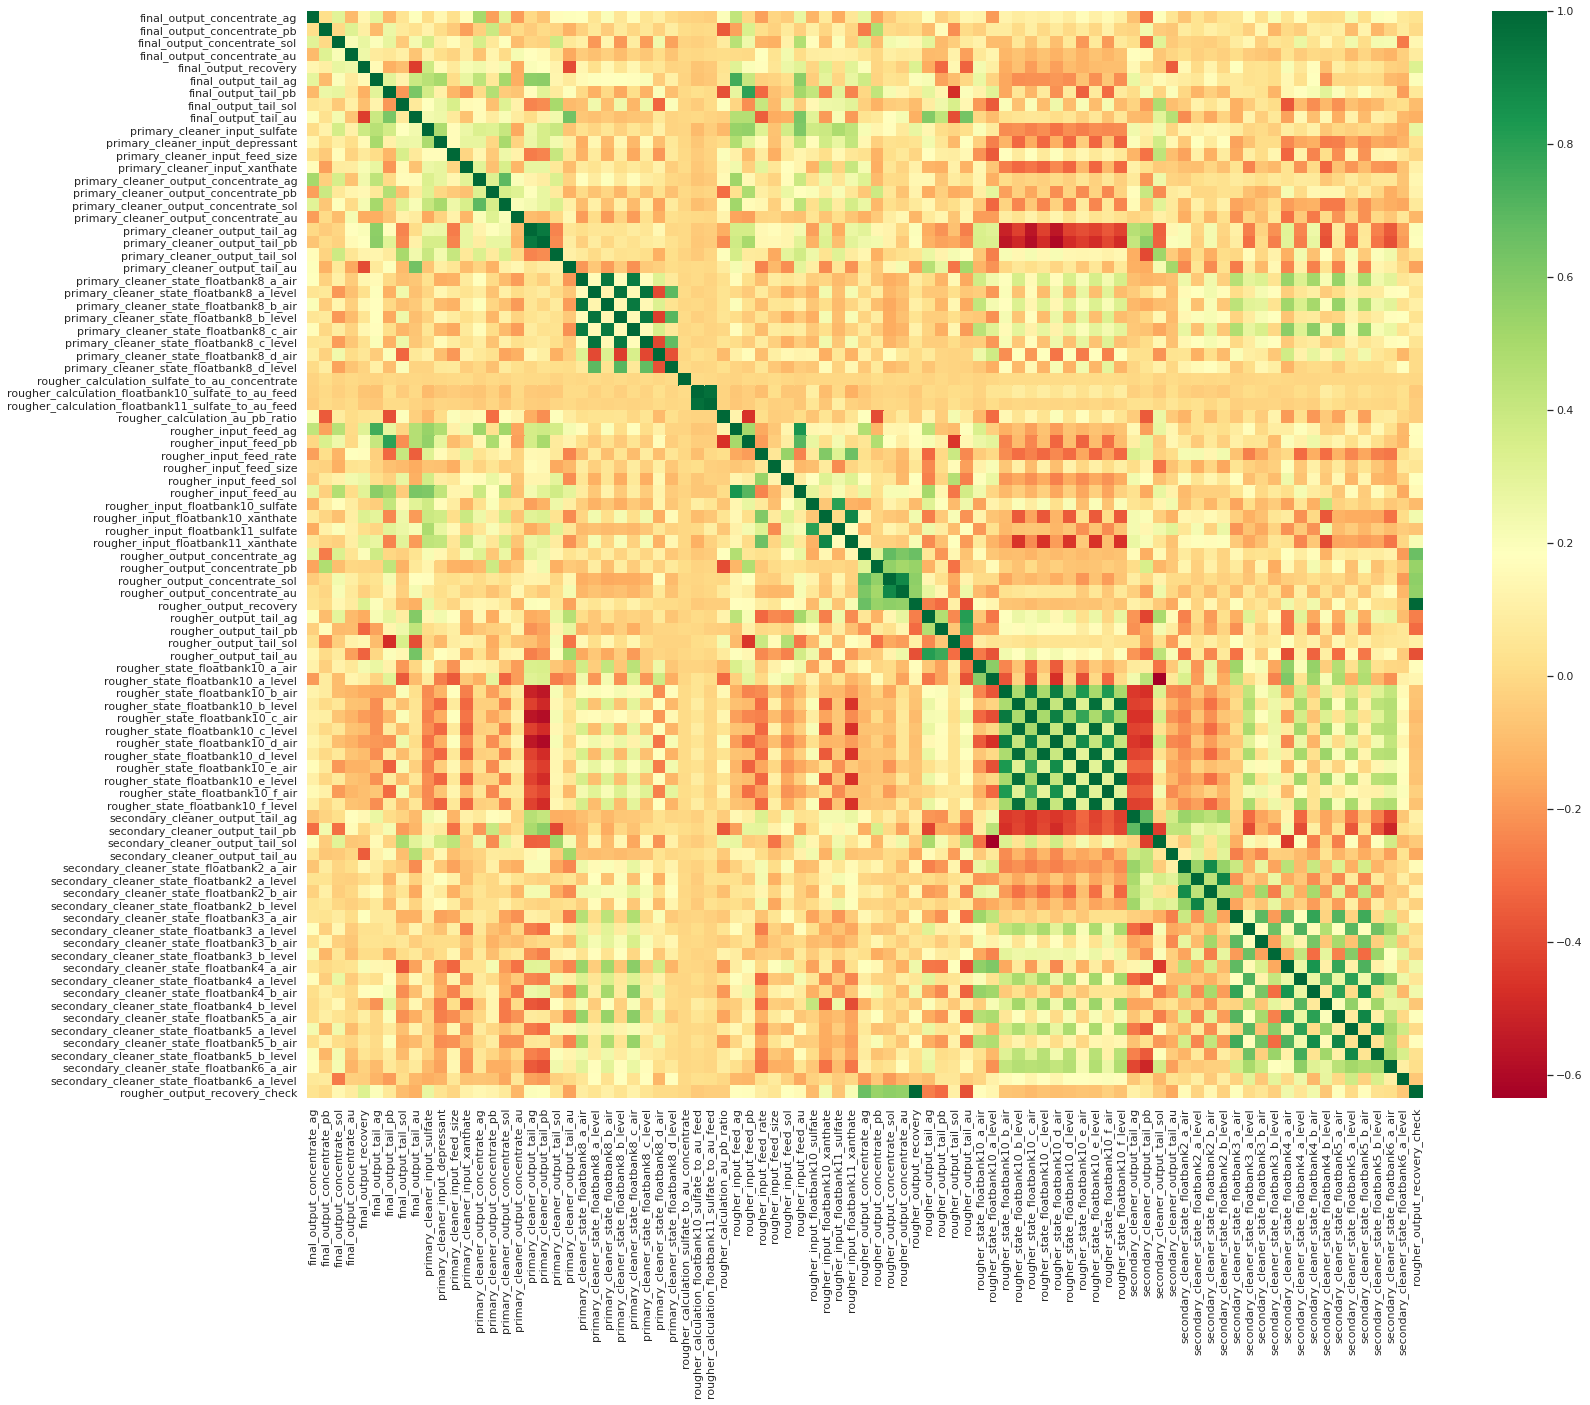

In [ ]:
sns.set(rc = {'figure.figsize':(25,20)})
sns.heatmap(data_train.corr(), cmap='RdYlGn')

Согласно полученной тепловой карте, сильная корреляция имеется по параметрам реагенты и этапов.

Вывыдем по каждому столбцу гистограмму и дигарамму размаха.

In [ ]:
for i in data_train.columns:
  fig, ax = plt.subplots(1 ,2, figsize=(12,4))
  fig.suptitle(i)
  ax[0].hist(data_train[i], bins=50);
  ax[1].boxplot(x=data_train[i]);
  ax[0].set_xlabel('Гистограмма')
  ax[1].set_xlabel('Диаграмма размаха')
  data_train[i].describe()

Output hidden; open in https://colab.research.google.com to view.

Данных много и в большинстве своем имеються выбросы. Но для того чтобы понимать границу имеющее место значение и выброс необходимо это проговорить с Заказчиком. Так как мы не можем этого сделать оставляю данные как есть.

<a id="6-bullet"></a>
**Посмотрим изменение концентрации металлов после каждого этапа.**

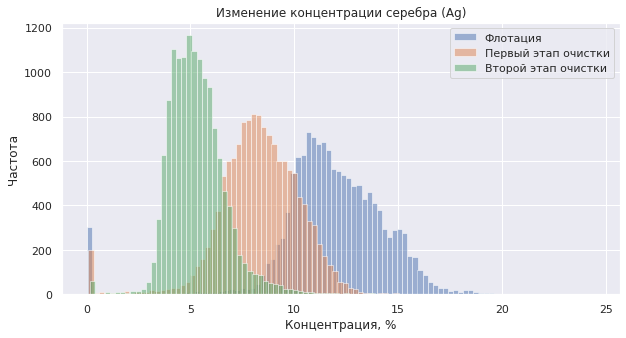

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(
    data_train[['rougher_output_concentrate_ag', 'primary_cleaner_output_concentrate_ag', 'final_output_concentrate_ag']],
    width = 0.25, bins=100, alpha=0.5, label=['Флотация', 'Первый этап очистки', 'Второй этап очистки'])
plt.legend(loc='upper right')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота')
plt.title('Изменение концентрации серебра (Ag)')
plt.show()

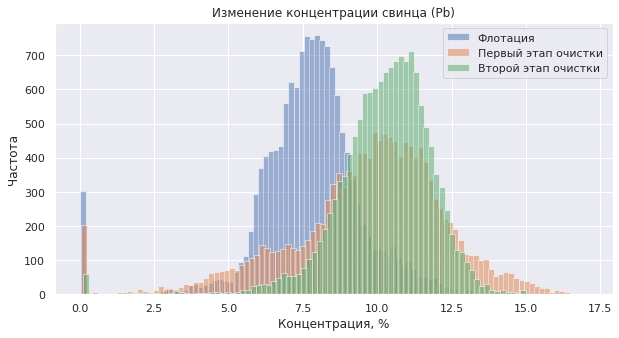

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(
    data_train[['rougher_output_concentrate_pb', 'primary_cleaner_output_concentrate_pb', 'final_output_concentrate_pb']],
    width = 0.2, bins=100, alpha=0.5, label=['Флотация', 'Первый этап очистки', 'Второй этап очистки'])
plt.legend(loc='upper right')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота')
plt.title('Изменение концентрации свинца (Pb)')
plt.show()

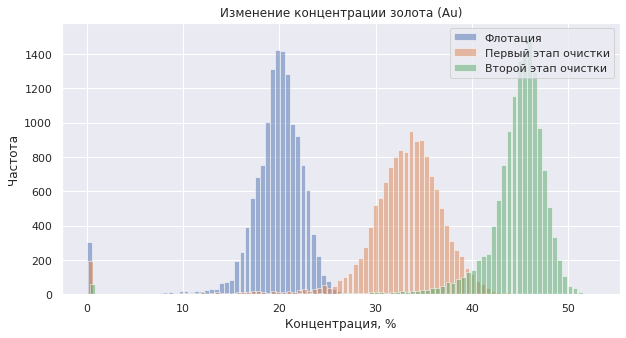

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(data_train[['rougher_output_concentrate_au', 'primary_cleaner_output_concentrate_au', 'final_output_concentrate_au']], width = 0.5, bins=100, alpha=0.5, label=['Флотация', 'Первый этап очистки', 'Второй этап очистки'])
plt.legend(loc='upper right')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота')
plt.title('Изменение концентрации золота (Au)')
plt.show()

Серебро после каждого этапа очистки уменьшается, разброс в концентрации с каждым этапом уменьшается. Золото наоборот, после каждого этапа все увеличивается, и разброс концентрации уменьшается. Концентрация свинца после флотации увеличиваеться, и далее не меняеться, предполагаю что это связано с химическими процессами на первом и втором этапах очистки.

<a id="7-bullet"></a>
**Сопоставим распеределение размера гранул на обучающей и тестовых выборках. Для удобства сформируем отдельный датафрейм.**

In [ ]:
combined_df = pd.DataFrame({'train': data_train['rougher_input_feed_size'],
                             'test': data_test['rougher_input_feed_size']})

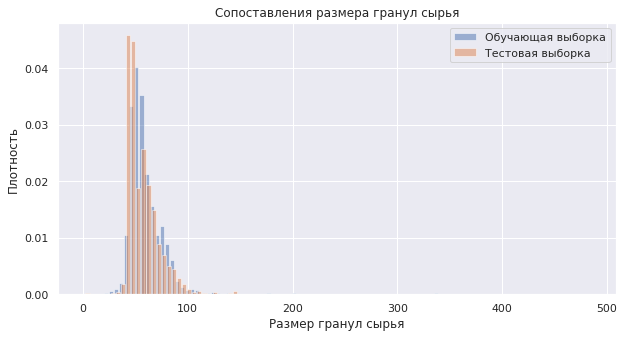

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(combined_df, bins=100, alpha=0.5, width = 4, density=True, label=['Обучающая выборка', 'Тестовая выборка'])

plt.legend(loc='upper right')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Плотность')
plt.title('Сопоставления размера гранул сырья')
plt.show()

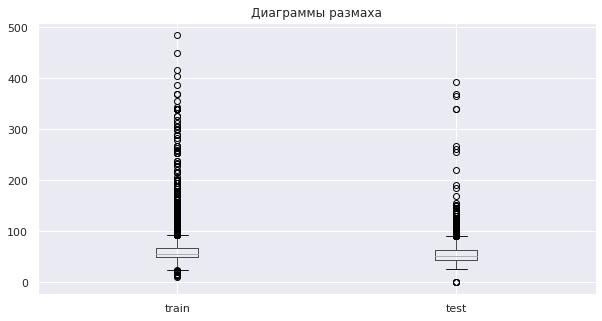

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Диаграммы размаха')
combined_df.boxplot();

In [ ]:
combined_df.describe()

,train,test
count,14149.000000,5290.000000
mean,60.239856,55.952754
std,23.005310,19.080334
min,9.659576,0.046369
25%,48.966751,43.906504
50%,55.269784,50.846843
75%,66.007526,62.451165
max,484.967466,392.494040


По построенному графику и таблице мы видим что достаточно распределения близки.

<a id="8-bullet"></a>
**Исследуем суммарные концентрации элементов на каждом этапе.**


In [ ]:
data_train['final_output_concentrate_all'] = data_train['final_output_concentrate_ag'] + data_train['final_output_concentrate_pb'] + data_train['final_output_concentrate_sol'] + data_train['final_output_concentrate_au']

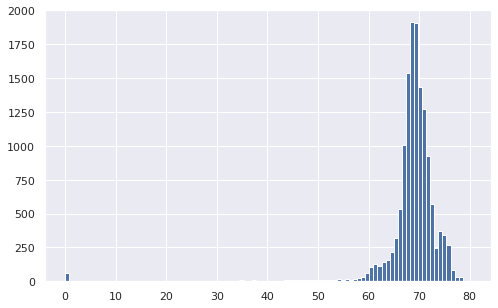

In [ ]:
data_train['final_output_concentrate_all'].hist(bins=100, figsize=(8, 5));

In [ ]:
data_train['rougher_output_concentrate_all'] = data_train['rougher_output_concentrate_ag'] + data_train['rougher_output_concentrate_pb'] + data_train['rougher_output_concentrate_sol'] + data_train['rougher_output_concentrate_au']

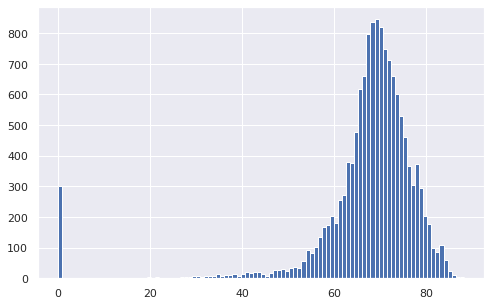

In [ ]:
data_train['rougher_output_concentrate_all'].hist(bins=100, figsize=(8, 5));

In [ ]:
data_train['rougher_input_feed__all'] = data_train['rougher_input_feed_ag'] + data_train['rougher_input_feed_pb'] + data_train['rougher_input_feed_sol'] + data_train['rougher_input_feed_au']

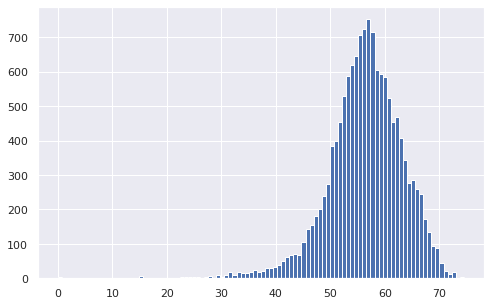

In [ ]:
data_train['rougher_input_feed__all'].hist(bins=100, figsize=(8, 5));

In [ ]:
data_train[['rougher_input_feed__all', 'rougher_output_concentrate_all', 'final_output_concentrate_all']].describe()

,rougher_input_feed__all,rougher_output_concentrate_all,final_output_concentrate_all
count,14149.000000,14149.000000,14149.000000
mean,56.242170,67.173145,68.387872
std,7.029808,12.713129,7.023723
min,0.040000,0.000000,0.000000
25%,52.573579,64.914390,67.559819
50%,56.627635,69.175663,69.141502
75%,60.763234,73.429261,70.974661
max,74.458253,88.140119,80.210644


По построенным графикам видим что, на входе во флотацию суммарная концентрация элементов имеет среднее значение ~58 единиц и имеет достаточно большой размах распределения, после флотации средняя величина приближается к 70 единицам (т.е. суммарная концентрация увеличилась), диапазон разброса уменьшился, но появились аномальные значения по сумммарной концентрации равные "0". После двух этапов очистки у нас средняя суммарная концентрация сконцентрировалось в районе 70 и диапазон распеределения стал горажде уже. Можно сделать вывод что с каждым этапаом очистки диапозон разброса концетрации элементов сужается и сама концентрация увеличивается, что гооворит о правильной работе системы очистки. Исследование также позволило выявить ряд аномалий с нулевой концентрацией. Возможная причина - сбой в датчике учета.

Удалим строки где концентрация равно 0.

In [ ]:
data_train.shape

(14149, 90)

In [ ]:
data_train = data_train.loc[(data_train['final_output_concentrate_all'] > 0) & (data_train['rougher_input_feed__all'] > 0) & (data_train['rougher_output_concentrate_all'] > 0)]

In [ ]:
data_train.shape

(13795, 90)

**Вывод:** Заполненны пустые значения в датасетах, методом ffill. Представлены изменения концентрации металлов на каждом этапе. Проведена очистка данных по выбросам (суммарные концентрации элементов равные "0"). Проведена проверка расчета эффективности обогащения.


## **Подбор модели**

<a id="9-bullet"></a>
**Напишем функцию для вычесления метрики sMAPE и итоговой**

In [ ]:
def sMAPE(target, predict):
  values = []
  for i in range(len(target)):
    values.append((abs(target[i] - predict[i])) / ((abs(target[i]) + abs(predict[i])) / 2))
  return sum(values) / len(values) * 100

In [ ]:
def sMAPE_finish(sMAPE_rougher, sMAPE_final):
  return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

Подготовим выборки к обучению, выделим отдельно признаки и целевые признаки. Для начала отбросим лишние колонки в обучаещей выборке.

In [ ]:
data_train = data_train[data_test.columns]

Сравним есть ли у нас различие по названиям стобцов в обучающей и тестовой выборках.

In [ ]:
list(set(data_train.columns.tolist()).symmetric_difference(data_test.columns.tolist()))

[]

Разделим целевые признаки от фич.

In [ ]:
target_train_rougher = data_train['rougher_output_recovery']
target_train_final = data_train['final_output_recovery']
features_train = data_train.drop(['rougher_output_recovery','final_output_recovery'], axis=1)

In [ ]:
target_test_rougher = data_test['rougher_output_recovery']
target_test_final = data_test['final_output_recovery']
features_test = data_test.drop(['rougher_output_recovery','final_output_recovery'], axis=1)

Проведем масштабирование признаков на обучающей и тестовой выборках.

In [ ]:
col = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train[col])
features_train[col] = scaler.transform(features_train[col])
features_test[col] = scaler.transform(features_test[col])

Т.к. для вычисления sMAPE на этапе rougher нам отдельно понадобяться данные которые относяться именно к этому этапу, то сформируем отдельный датасет. Для обучения и получения sMAPE на финальном этапе будет использовать все данные, в том числе и с этапа флотации.

In [ ]:
rougher_col_train = [x for x in col if re.match('^rougher', x)]

In [ ]:
features_train_rougher = features_train[rougher_col_train]
features_test_rougher = features_test[rougher_col_train]

Подбор модели.

In [ ]:
RANDOM_STATE = 55555

<a id="*10*-bullet"></a>
**Линейная модель**

In [ ]:
model = LinearRegression()

sMAPE_rougher = -cross_val_score(model, features_train_rougher, target_train_rougher, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5).mean()
print(f'sMAPE_rougher: ', sMAPE_rougher)
print('--'*60)

sMAPE_final = -cross_val_score(model, features_train, target_train_final, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5).mean()
print(f'sMAPE_final: ', sMAPE_final)
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(sMAPE_rougher, sMAPE_final))

sMAPE_rougher:  6.660435975748048
------------------------------------------------------------------------------------------------------------------------
sMAPE_final:  10.990200515158017
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  9.907759380305526


In [ ]:
#сформируем массив где будем сохранять полученные результаты
scores = []
scores.append(['LinearRegression', sMAPE_rougher.round(2), sMAPE_final.round(2), sMAPE_finish(sMAPE_rougher, sMAPE_final).round(2)])

<a id="11-bullet"></a>
**Модель дерева решения**

In [ ]:
parametrs_dtr = {'max_depth': range (2, 30),
             'min_samples_split': range (2,10),
             'min_samples_leaf': range (2,8)
              }
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

dtr_r = RandomizedSearchCV(dtr, parametrs_dtr, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
dtr_r.fit(features_train_rougher, target_train_rougher)
print(f'Параметры лучшей модели_rougher: ', dtr_r.best_estimator_)
print(f'sMAPE_rougher лучшей модели: ', dtr_r.best_score_*(-1))
print('--'*60)

dtr_f = RandomizedSearchCV(dtr, parametrs_dtr, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
dtr_f.fit(features_train, target_train_final)
print(f'Параметры лучшей модели_final: ', dtr_f.best_estimator_)
print(f'sMAPE_final лучшей модели: ', dtr_f.best_score_*(-1))
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(dtr_r.best_score_*(-1), dtr_f.best_score_*(-1)))

Параметры лучшей модели_rougher:  DecisionTreeRegressor(max_depth=8, min_samples_leaf=7, random_state=55555)
sMAPE_rougher лучшей модели:  7.746724222394361
------------------------------------------------------------------------------------------------------------------------
Параметры лучшей модели_final:  DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=8,
                      random_state=55555)
sMAPE_final лучшей модели:  9.63142864868654
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  9.160252542113495


In [ ]:
scores.append(['DecisionTreeRegressor', (dtr_r.best_score_*(-1)).round(2), (dtr_f.best_score_*(-1)).round(2), sMAPE_finish(dtr_r.best_score_*(-1), dtr_f.best_score_*(-1)).round(2)])

<a id="12-bullet"></a>
**Модель случайный лес**

In [ ]:
parametrs = {'max_depth': range (2, 30),
             'min_samples_split': range (2,10),
             'min_samples_leaf': range (2,8),
             'n_estimators': range (10,30)
              }

rfr = RandomForestRegressor(random_state=RANDOM_STATE)

rfr_r = RandomizedSearchCV(rfr, parametrs, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
rfr_r.fit(features_train_rougher, target_train_rougher)
print(f'Параметры лучшей модели_rougher: ', rfr_r.best_estimator_)
print(f'sMAPE_rougher лучшей модели: ', rfr_r.best_score_*(-1))
print('--'*60)

rfr_f = RandomizedSearchCV(rfr, parametrs, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
rfr_f.fit(features_train, target_train_final)
print(f'Параметры лучшей модели_final: ', rfr_f.best_estimator_)
print(f'sMAPE_final лучшей модели: ', rfr_f.best_score_*(-1))
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(rfr_r.best_score_*(-1), rfr_f.best_score_*(-1)))

Параметры лучшей модели_rougher:  RandomForestRegressor(max_depth=22, min_samples_leaf=4, min_samples_split=9,
                      n_estimators=14, random_state=55555)
sMAPE_rougher лучшей модели:  6.587176149957531
------------------------------------------------------------------------------------------------------------------------
Параметры лучшей модели_final:  RandomForestRegressor(max_depth=4, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=16, random_state=55555)
sMAPE_final лучшей модели:  9.191753939091544
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  8.540609491808041


In [ ]:
scores.append(['RandomForestRegressor', (rfr_r.best_score_*(-1)).round(2), (rfr_f.best_score_*(-1)).round(2), sMAPE_finish(rfr_r.best_score_*(-1), rfr_f.best_score_*(-1)).round(2)])

**Модель Ridge**

In [ ]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge = Ridge()

ridge_r = RandomizedSearchCV(ridge, parameters, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
ridge_r.fit(features_train_rougher, target_train_rougher)

print(f'Параметры лучшей модели_rougher: ', ridge_r.best_estimator_)
print(f'sMAPE_rougher лучшей модели: ', ridge_r.best_score_*(-1))
print('--'*60)

ridge_f = RandomizedSearchCV(ridge, parameters, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
ridge_f.fit(features_train, target_train_final)
print(f'Параметры лучшей модели_final: ', ridge_f.best_estimator_)
print(f'sMAPE_final лучшей модели: ', ridge_f.best_score_*(-1))
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(ridge_r.best_score_*(-1), ridge_f.best_score_*(-1)))

Параметры лучшей модели_rougher:  Ridge(alpha=20)
sMAPE_rougher лучшей модели:  6.616853587680775
------------------------------------------------------------------------------------------------------------------------
Параметры лучшей модели_final:  Ridge(alpha=20)
sMAPE_final лучшей модели:  10.854936158302147
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  9.795415515646804


In [ ]:
scores.append(['Ridge', (ridge_r.best_score_*(-1)).round(2), (ridge_f.best_score_*(-1)).round(2), sMAPE_finish(ridge_r.best_score_*(-1), ridge_f.best_score_*(-1)).round(2)])

**Модель Lasso**

In [ ]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso = Lasso()

lasso_r = RandomizedSearchCV(lasso, parameters, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
lasso_r.fit(features_train_rougher, target_train_rougher)

print(f'Параметры лучшей модели_rougher: ', lasso_r.best_estimator_)
print(f'sMAPE_rougher лучшей модели: ', lasso_r.best_score_*(-1))
print('--'*60)

lasso_f = RandomizedSearchCV(lasso, parameters, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5, n_iter = 10, n_jobs=-1)
lasso_f.fit(features_train, target_train_final)
print(f'Параметры лучшей модели_final: ', lasso_f.best_estimator_)
print(f'sMAPE_final лучшей модели: ', lasso_f.best_score_*(-1))
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(lasso_r.best_score_*(-1), lasso_f.best_score_*(-1)))

Параметры лучшей модели_rougher:  Lasso(alpha=0.01)
sMAPE_rougher лучшей модели:  6.586683069291176
------------------------------------------------------------------------------------------------------------------------
Параметры лучшей модели_final:  Lasso(alpha=1)
sMAPE_final лучшей модели:  9.352864605763639
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  8.661319221645524


In [ ]:
scores.append(['Lasso', (lasso_r.best_score_*(-1)).round(2), (lasso_f.best_score_*(-1)).round(2), sMAPE_finish(lasso_r.best_score_*(-1), lasso_f.best_score_*(-1)).round(2)])

Выведим таблицу с результатами метрик sMAPE на экран

In [ ]:
scores = pd.DataFrame(scores, columns=['model', 'sMAPE_rougher','sMAPE_final', 'sMAPE_finish'])
scores

,model,sMAPE_rougher,sMAPE_final,sMAPE_finish
0,LinearRegression,6.66,10.99,9.91
1,DecisionTreeRegressor,7.75,9.63,9.16
2,RandomForestRegressor,6.59,9.19,8.54
3,Ridge,6.62,10.85,9.80
4,Lasso,6.59,9.35,8.66


Согласно полученным результатам лучшей моделью становиться RandomForestRegressor.

<a id="13-bullet"></a>
**Вычисление метрик sMAPE на тестовой выборке на лучшей модели**

In [ ]:
pred_rougher = rfr_r.best_estimator_.predict(features_test_rougher)
sMAPE_rouger_test = sMAPE(target_test_rougher, pred_rougher)

print(f'sMAPE_rougher для тестовой выборки: ', sMAPE_rouger_test)
print('--'*60)

pred_final = rfr_f.best_estimator_.predict(features_test)
sMAPE_final_test = sMAPE(target_test_final, pred_final)

print(f'sMAPE_final для тестовой выборки: ', sMAPE_final_test)
print('--'*60)

print('Итоговый sMAPE для тестовой выборки: ', sMAPE_finish(sMAPE_rouger_test, sMAPE_final_test))

sMAPE_rougher для тестовой выборки:  8.283239161149426
------------------------------------------------------------------------------------------------------------------------
sMAPE_final для тестовой выборки:  9.737270178451936
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE для тестовой выборки:  9.373762424126308


**Вывод:** Проведен подбор лучшей модели на обучающей выборке методом кросс-валидации. На результатам полученных метрик выбрана модель случайного леса. По лучшей модели проведена оценка эффективности прогноза, итоговый sMAPE=9.321097436881882.

Сравним результаты с константной моделью

In [ ]:
dr_mean_r = DummyRegressor(strategy = 'mean').fit(features_train_rougher, target_train_rougher)
sMAPE_rougher_dr = sMAPE(target_test_rougher, dr_mean_r.predict(features_test_rougher))
print(f'sMAPE_rougher: ', sMAPE_rougher_dr)
print('--'*60)

dr_mean_f = DummyRegressor(strategy = 'mean').fit(features_train, target_train_final)
sMAPE_final_dr = sMAPE(target_test_final, dr_mean_f.predict(features_test))
print(f'sMAPE_final: ', sMAPE_final_dr)
print('--'*60)

print('Итоговый sMAPE: ', sMAPE_finish(sMAPE_rougher_dr, sMAPE_final_dr))

sMAPE_rougher:  9.066630806401546
------------------------------------------------------------------------------------------------------------------------
sMAPE_final:  10.074847136380457
------------------------------------------------------------------------------------------------------------------------
Итоговый sMAPE:  9.82279305388573


<a id="*14*-bullet"></a>
## **Общий вывод**

В рамках проекта было выполненно:
Анализ исходных данных
Устранение пустых значений
Выявление корреляционных зависимостей
Анализ концентраций металлов на каждом этапе очистки
Проверка размера гранул руды на обучающей и тестовых выборках
Подбор лучшей модели на обучающей выборке
Расчет метрики на тестовой выборке.

Лучшей моделью оказалось модель случайного леса. На обучающей выборке результаты:</br>
* sMAPE_rougher:  6.587176149957531
* sMAPE_final:  9.191753939091544
* Итоговый sMAPE:  8.540609491808041

**На тестовой выборке были получены следующие результаты:</br>**
* **sMAPE_rougher:  8.283239161149426**
* **sMAPE_final:  9.737270178451936**
* **Итоговый sMAPE:  9.373762424126308**